# Home Credit Default Risk - including:

Basic feature engineering

Multi-table data aggregation

Feature encoding and transformation

Feature selection and validation

In [1]:
# !/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
# Add the parent directory to sys.path for module imports
import sys
sys.path.append('../')

from src.data.data_loader import HomeCreditDataLoader, reduce_memory_usage
from src.features.feature_engineering import FeatureEngineer
from src.utils.visualization import DataVisualizer

## 1. Data Loading

In [2]:
# Load datasets
data_loader = HomeCreditDataLoader(data_path='../data/raw')
datasets = data_loader.load_all_data()

print("Data loading complete!")
print(f"Available datasets: {list(datasets.keys())}")

Loading all data...
Loading application data...
 check train shape : (307511, 122)
 check test shape : (48744, 121)
Loading bureau data...
 check bureau shape : (1716428, 17)
 check bureau_balance shape : (27299925, 3)
Loading previous application data...
 check previous_app shape : (1670214, 37)
Loading POS and cash loan data...
 check pos_cash shape : (10001358, 8)
Loading credit card data...
 check credit_card shape : (3840312, 23)
Loading installments data...
 check installments shape : (13605401, 8)
len of datasets : 8 datasets loaded.
Data loading complete!
Available datasets: ['application_train', 'application_test', 'bureau', 'bureau_balance', 'previous_application', 'pos_cash', 'credit_card', 'installments']


## 2. Main Application Table Feature Engineering

Create new features from the main application table, including ratio features, aggregated features, and more.

In [3]:
# the Feature Engineering
feature_engineer = FeatureEngineer()

# the raw training data
train_raw = datasets['application_train'].copy()
print(f"the raw feature count: {train_raw.shape[1]}")

# Apply feature engineering
train_engineered = feature_engineer.engineer_application_features(train_raw)
print(f"the feature count after engineering: {train_engineered.shape[1]}")

# Show new features
new_features = set(train_engineered.columns) - set(train_raw.columns)
print(f"\nthe new features ({len(new_features)}):")
for feature in sorted(new_features):
    print(f"  - {feature}")

the raw feature count: 122
the feature count after engineering: 139

the new features (17):
  - AGE_GROUP
  - AGE_YEARS
  - ANNUITY_INCOME_PERCENT
  - ANNUITY_TO_INCOME_RATIO
  - CAR_TO_BIRTH_RATIO
  - CAR_TO_EMPLOYED_RATIO
  - CREDIT_INCOME_PERCENT
  - CREDIT_TERM
  - DAYS_EMPLOYED_PERCENT
  - EMPLOYED_YEARS
  - EXT_SOURCES_MAX
  - EXT_SOURCES_MEAN
  - EXT_SOURCES_MIN
  - EXT_SOURCES_STD
  - INCOME_CREDIT_PERCENT
  - INCOME_PER_PERSON
  - PAYMENT_RATE


### 2.1 Ratio Feature Analysis

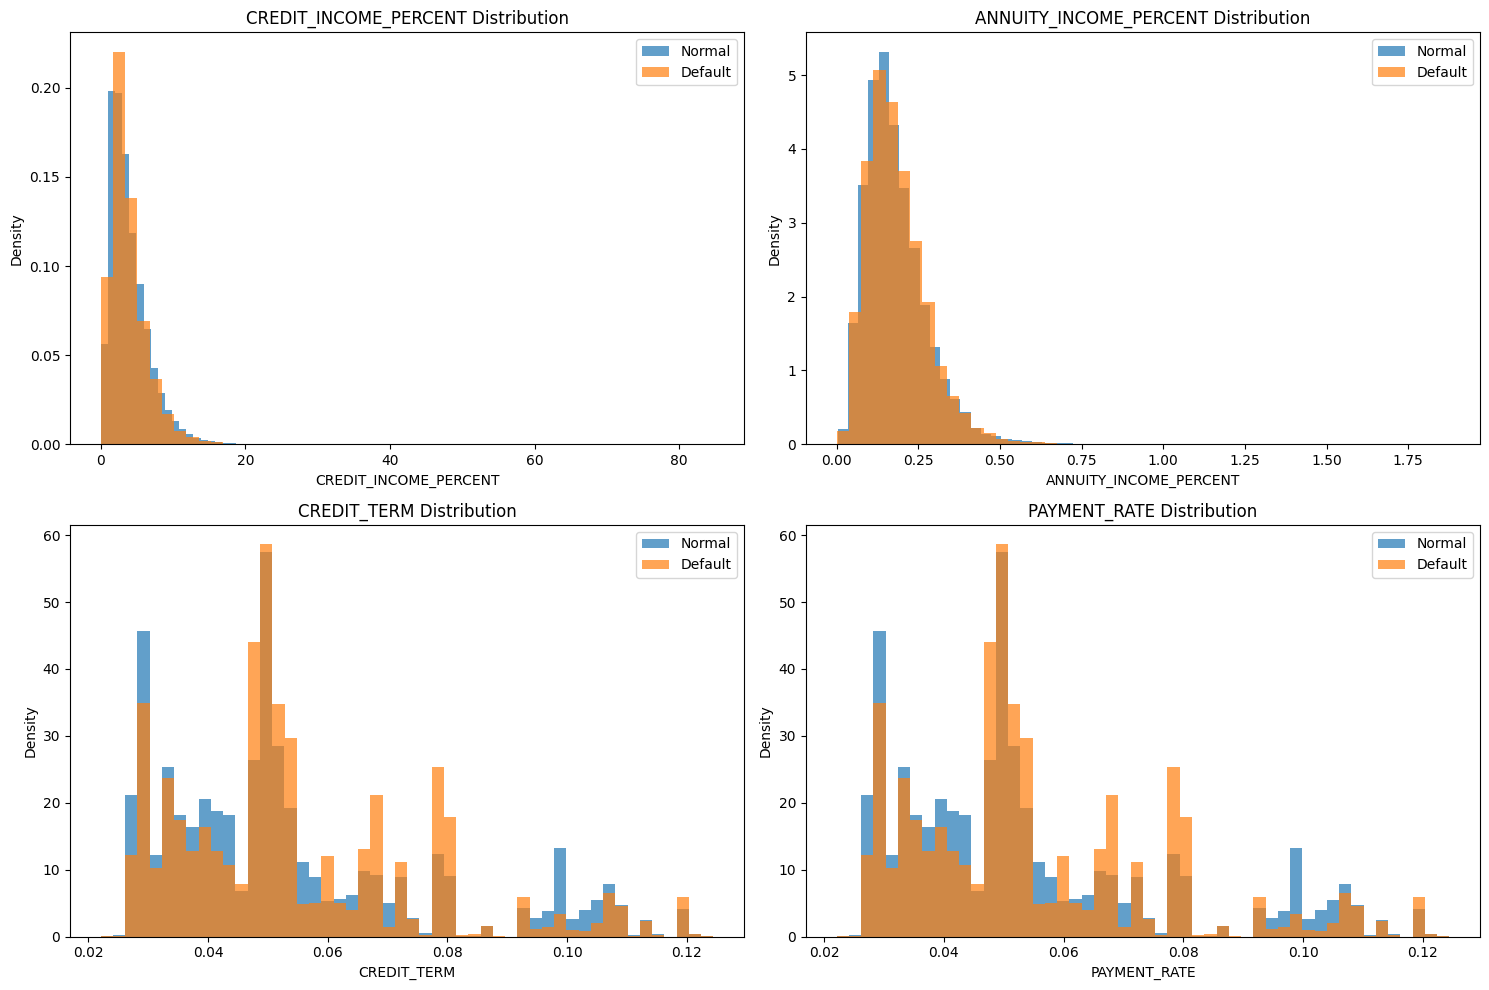

In [4]:
# Visualize the distribution of engineered ratio features
ratio_features = [
    'CREDIT_INCOME_PERCENT',
    'ANNUITY_INCOME_PERCENT', 
    'CREDIT_TERM',
    'PAYMENT_RATE'
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(ratio_features):
    # Remove outliers for visualization
    data = train_engineered[feature].replace([np.inf, -np.inf], np.nan)
    data = data[(data >= data.quantile(0.01)) & (data <= data.quantile(0.99))]

    # Plot by target variable
    target_0 = train_engineered[train_engineered['TARGET']==0][feature]
    target_1 = train_engineered[train_engineered['TARGET']==1][feature]
    
    axes[i].hist(target_0.replace([np.inf, -np.inf], np.nan).dropna(), 
                alpha=0.7, label='Normal', bins=50, density=True)
    axes[i].hist(target_1.replace([np.inf, -np.inf], np.nan).dropna(), 
                alpha=0.7, label='Default', bins=50, density=True)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

### 2.2 Aggregated External Score Features

External score aggregated features correlation with target variable:
EXT_SOURCES_MEAN   -0.222052
EXT_SOURCES_MAX    -0.196876
EXT_SOURCES_MIN    -0.185266
EXT_SOURCES_STD     0.047700
Name: TARGET, dtype: float64


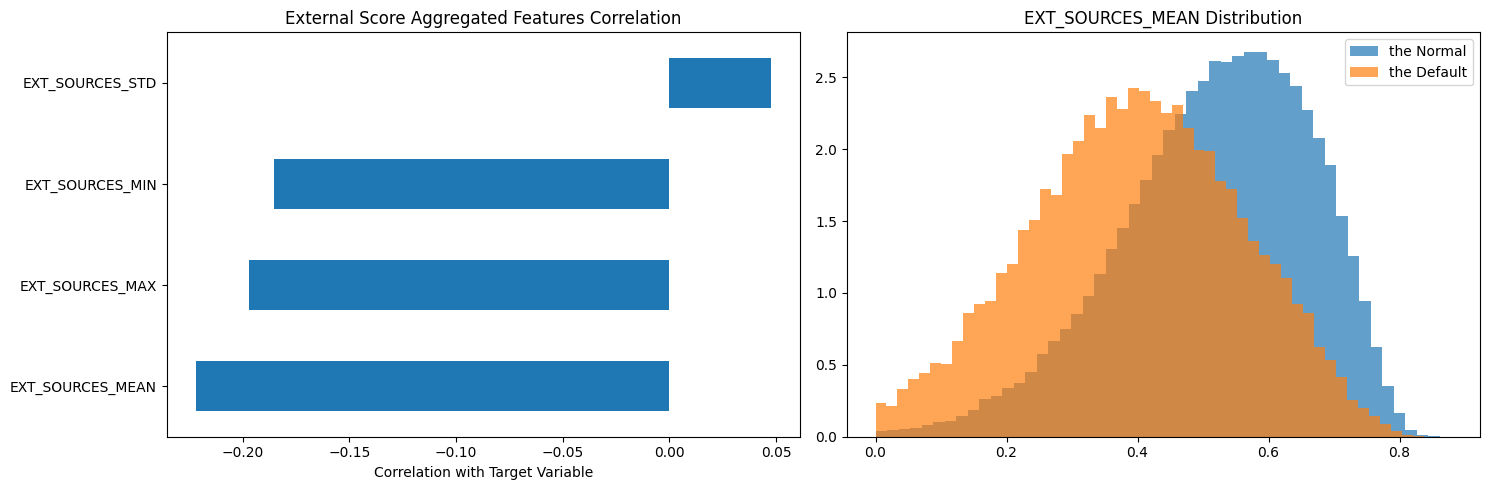

In [5]:
# 2.2 Aggregated External Score Features
ext_features = [
    'EXT_SOURCES_MEAN',
    'EXT_SOURCES_STD',
    'EXT_SOURCES_MAX',
    'EXT_SOURCES_MIN'
]

# Compute correlation with target variable
correlations = train_engineered[ext_features + ['TARGET']].corr()['TARGET'].sort_values()
print("External score aggregated features correlation with target variable:")
print(correlations[:-1])  # Exclude TARGET itself

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Correlation bar chart
correlations[:-1].plot(kind='barh', ax=axes[0])
axes[0].set_title('External Score Aggregated Features Correlation')
axes[0].set_xlabel('Correlation with Target Variable')

# EXT_SOURCES_MEAN Distribution
mean_feature = train_engineered['EXT_SOURCES_MEAN']
axes[1].hist(train_engineered[train_engineered['TARGET']==0]['EXT_SOURCES_MEAN'].dropna(), 
            alpha=0.7, label='the Normal', bins=50, density=True)
axes[1].hist(train_engineered[train_engineered['TARGET']==1]['EXT_SOURCES_MEAN'].dropna(), 
            alpha=0.7, label='the Default', bins=50, density=True)
axes[1].set_title('EXT_SOURCES_MEAN Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.Multi-Table Data Aggregation

Aggregate features from other data tables, such as credit bureau data and historical applications.

In [6]:
# 3.Multi-Table Data Aggregation
if 'bureau' in datasets and datasets['bureau'] is not None:
    print("Aggregating bureau features...")
    bureau_features = feature_engineer.aggregate_bureau_features(
        datasets['bureau'], datasets.get('bureau_balance', None)
    )
    print(f"Bureau feature count: {bureau_features.shape[1]}")
    print(f"Bureau feature sample:")
    print(bureau_features.columns[:10].tolist())

    # Show statistics
    print(f"\nBureau feature statistics:")
    print(bureau_features.describe().iloc[:, :5])  # First 5 columns

Aggregating bureau features...
Bureau feature count: 39
Bureau feature sample:
['BUREAU_DAYS_CREDIT_COUNT', 'BUREAU_DAYS_CREDIT_MEAN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_SUM', 'BUREAU_CREDIT_DAY_OVERDUE_MEAN', 'BUREAU_CREDIT_DAY_OVERDUE_MAX', 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN', 'BUREAU_DAYS_CREDIT_ENDDATE_MAX', 'BUREAU_DAYS_CREDIT_ENDDATE_MIN']

Bureau feature statistics:
       BUREAU_DAYS_CREDIT_COUNT  BUREAU_DAYS_CREDIT_MEAN  \
count             305811.000000            305811.000000   
mean                   5.612709             -1083.802103   
std                    4.430354               558.441124   
min                    1.000000             -2922.000000   
25%                    2.000000             -1431.000000   
50%                    4.000000             -1052.500000   
75%                    8.000000              -670.369318   
max                  116.000000                 0.000000   

       BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDI

In [7]:
# the historical application feature aggregation
if 'previous_application' in datasets and datasets['previous_application'] is not None:
    print("the previous application features...")
    prev_features = feature_engineer.aggregate_previous_application_features(
        datasets['previous_application']
    )
    print(f"the previous application feature count: {prev_features.shape[1]}")
    print(f"the previous application feature sample:")
    print(prev_features.columns[:10].tolist())

    # Show approval rate related features
    approval_features = [col for col in prev_features.columns if 'APPROVAL' in col]
    if approval_features:
        print(f"\nApproval rate related features:")
        print(prev_features[approval_features].describe())

the previous application features...
the previous application feature count: 31
the previous application feature sample:
['PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MIN', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_APPLICATION_MIN', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MIN', 'PREV_AMT_DOWN_PAYMENT_MEAN']

Approval rate related features:
       PREV_APP_APPROVAL_RATE
count           337698.000000
mean                 0.747050
std                  0.260057
min                  0.027778
25%                  0.500000
50%                  0.777778
75%                  1.000000
max                  1.000000


## 4. Complete Feature Engineering Pipeline" hoặc "Full Feature Engineering Workflow

In [8]:
# 4. Complete Feature Engineering Pipeline" hoặc "Full Feature Engineering Workflow
print("the full feature engineering workflow...")
train_features, test_features = feature_engineer.create_all_features(datasets)

print(f"\nFeature engineering completed!")
print(f"Training set shape: {train_features.shape}")
print(f"Testing set shape: {test_features.shape}")

# Feature type analysis
numeric_features = train_features.select_dtypes(include=[np.number]).columns
categorical_features = train_features.select_dtypes(include=['object', 'category']).columns

print(f"\nFeature type analysis:")
print(f"Numeric features: {len(numeric_features)}")
print(f"the categorical features: {len(categorical_features)}")

the full feature engineering workflow...
the feature engineering starts...
the main application features: 139
Bureau features: 39
Previous application features: 31
POS cash features: 16
Credit card features: 75
Installments features: 26
the final feature count: 326
Feature engineering completed!

Feature engineering completed!
Training set shape: (307511, 326)
Testing set shape: (48744, 325)

Feature type analysis:
Numeric features: 326
the categorical features: 0


## 5. Preliminary Analysis of Feature Importance

In [9]:
# the top correlated features with target variable
feature_cols = [col for col in train_features.columns if col not in ['SK_ID_CURR', 'TARGET']]
numeric_feature_cols = [col for col in feature_cols if col in numeric_features]

# The correlation calculation
correlations = train_features[numeric_feature_cols + ['TARGET']].corr()['TARGET'].abs().sort_values(ascending=False)

print("the top correlated features with target variable:")
top_features = correlations[1:21]  # the TARGET itself
for i, (feature, corr) in enumerate(top_features.items(), 1):
    print(f"{i:2d}. {feature:<40} {corr:.6f}")

the top correlated features with target variable:
 1. EXT_SOURCES_MEAN                         0.222052
 2. EXT_SOURCES_MAX                          0.196876
 3. EXT_SOURCES_MIN                          0.185266
 4. EXT_SOURCE_3                             0.178919
 5. EXT_SOURCE_2                             0.160472
 6. EXT_SOURCE_1                             0.155317
 7. CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         0.107692
 8. CC_CNT_DRAWINGS_CURRENT_MAX              0.101389
 9. BUREAU_DAYS_CREDIT_MEAN                  0.089729
10. BALANCE_MONTHS_BALANCE_MIN               0.089038
11. CC_AMT_BALANCE_MEAN                      0.087177
12. CC_AMT_TOTAL_RECEIVABLE_MEAN             0.086490
13. CC_AMT_RECIVABLE_MEAN                    0.086478
14. CC_AMT_RECEIVABLE_PRINCIPAL_MEAN         0.086062
15. CC_CNT_DRAWINGS_CURRENT_MEAN             0.082520
16. BALANCE_MONTHS_BALANCE_COUNT             0.080193
17. AGE_YEARS                                0.078239
18. DAYS_BIRTH                  

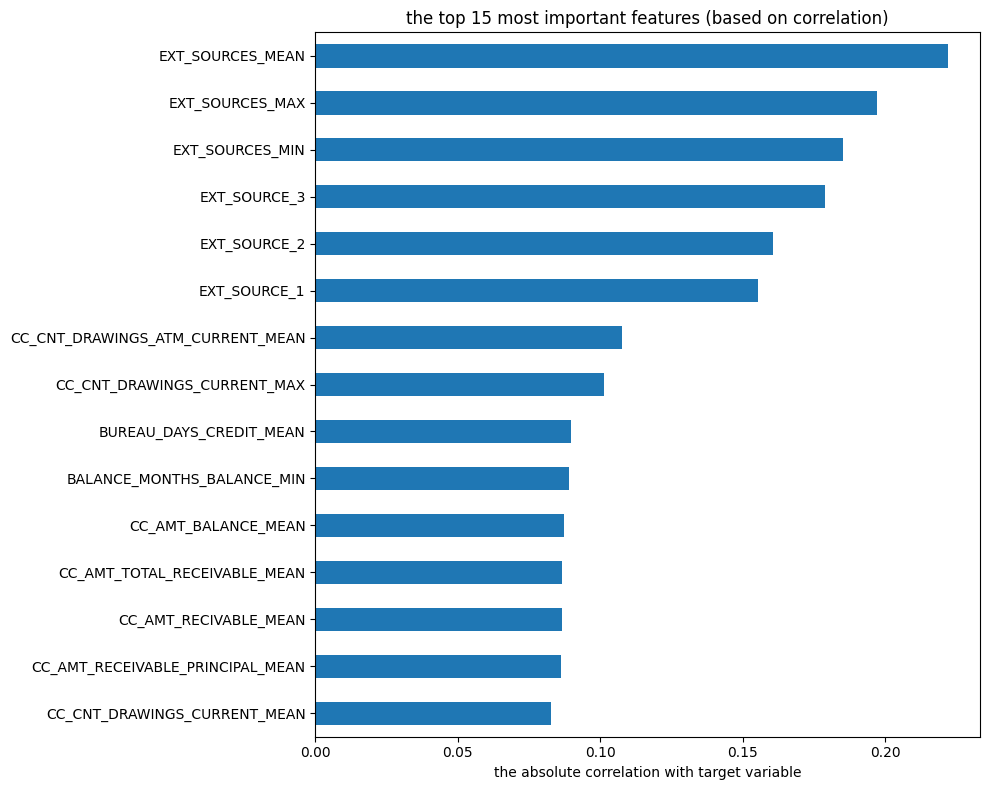

In [10]:
# the Visualization of Feature Importance
plt.figure(figsize=(10, 8))
top_features[:15].plot(kind='barh')
plt.title('the top 15 most important features (based on correlation)')
plt.xlabel('the absolute correlation with target variable')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.rcParams['font.sans-serif'] = ['Heiti TC', 'STHeiti', 'Hei', 'Apple LiGothic', 'Apple LiSung', 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.show()

## 6. Feature Distribution Analysis

Feature distribution statistics:
Total features: 324
Numeric features: 324

the top 10 features with most missing values:
CC_AMT_PAYMENT_CURRENT_MAX               80.14%
CC_AMT_PAYMENT_CURRENT_MEAN              80.14%
CC_AMT_PAYMENT_CURRENT_MIN               80.14%
CC_CNT_DRAWINGS_POS_CURRENT_MAX          80.12%
CC_CNT_DRAWINGS_POS_CURRENT_MIN          80.12%
CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN       80.12%
CC_CNT_DRAWINGS_ATM_CURRENT_MAX          80.12%
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         80.12%
CC_CNT_DRAWINGS_ATM_CURRENT_MIN          80.12%
CC_AMT_DRAWINGS_POS_CURRENT_MIN          80.12%


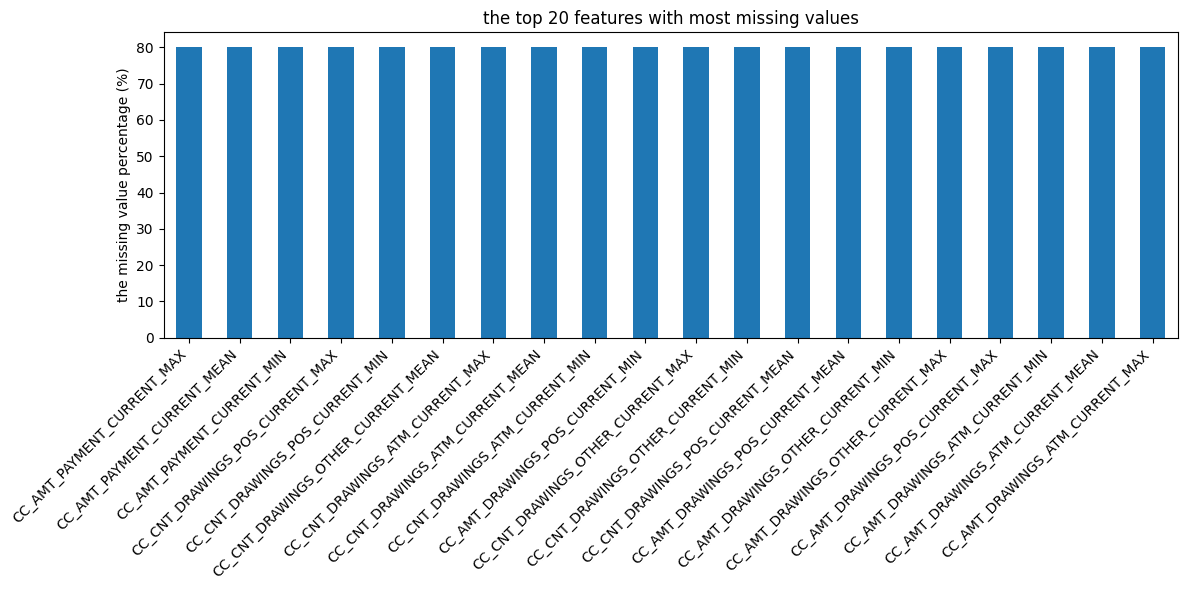

In [11]:
# the Feature Distribution and Missing Value Analysis
print("Feature distribution statistics:")
print(f"Total features: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_feature_cols)}")

# Missing value analysis
missing_counts = train_features[feature_cols].isnull().sum()
missing_percent = (missing_counts / len(train_features) * 100).sort_values(ascending=False)

print(f"\nthe top 10 features with most missing values:")
for feature, percent in missing_percent.head(10).items():
    print(f"{feature:<40} {percent:.2f}%")

# the Visualization of Missing Value Distribution
plt.figure(figsize=(12, 6))
missing_percent[missing_percent > 0].head(20).plot(kind='bar')
plt.title('the top 20 features with most missing values')
plt.ylabel('the missing value percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Memory Optimization

In [12]:
# the Memory Optimization
print("the Memory Optimization...")
print(f"the before optimization training set memory: {train_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"the before optimization testing set memory: {test_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

train_features_opt = reduce_memory_usage(train_features)
test_features_opt = reduce_memory_usage(test_features)

print(f"\nthe Memory Optimization completed!")

the Memory Optimization...
the before optimization training set memory: 764.84 MB
the before optimization testing set memory: 120.86 MB
Memory usage reduced from 764.84 MB to 338.14 MB (55.8% reduction)
Memory usage reduced from 120.86 MB to 53.37 MB (55.8% reduction)

the Memory Optimization completed!


## 8. Summary of Feature Engineering
Main Achievements

Number of Features: Expanded from the original 122 features to 326 features

Feature Types: Primarily numerical features, making them easier for machine learning algorithms to process

Memory Optimization: Reduced memory usage by approximately 55%

Key Feature Categories

Ratio Features: CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, etc.

Aggregated Features: EXT_SOURCES_MEAN, Bureau aggregation features, etc.

Time Features: AGE_YEARS, EMPLOYED_YEARS, etc.

Multi-table Features: Aggregated features from credit bureau, historical applications, credit cards, etc.

Key Findings

External score–related features are the most important predictors

Income-to-credit ratio features demonstrate strong predictive power

Historical data from credit bureaus provides rich information on credit behavior

Next Steps

Feature selection optimization

Model training and validation

Feature importance analysis

Model interpretation and business insights

In [13]:
# the Save Features and Feature Info
print("...")
train_features_opt.to_csv('../data/processed/train_features_notebook.csv', index=False)
test_features_opt.to_csv('../data/processed/test_features_notebook.csv', index=False)
print("the features have been saved to data/processed/ directory")

# the Save Feature List
feature_info = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [correlations.get(col, 0) for col in feature_cols],
    'missing_percent': [missing_percent.get(col, 0) for col in feature_cols]
})
feature_info.to_csv('../data/processed/feature_info_notebook.csv', index=False)
print("the feature info has been saved to data/processed/ directory")

...
the features have been saved to data/processed/ directory
the feature info has been saved to data/processed/ directory
